<img style="float: left; width: 220px;" src="images/shutterstock_318255209.jpg">

## <font color="grey"> $\quad$ Distinct proliferation rates - Methods </font>

$\newcommand{\vct}[1]{\mathbf{#1}}$
$\newcommand{\mtx}[1]{\mathbf{#1}}$
$\newcommand{\e}{\varepsilon}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\minimize}{\mathrm{minimize}\quad}$
$\newcommand{\maximize}{\mathrm{maximize}\quad}$
$\newcommand{\subjto}{\quad\text{subject to}\quad}$
$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\trans}{T}$
$\newcommand{\ip}[2]{\langle {#1}, {#2} \rangle}$
$\newcommand{\zerovct}{\vct{0}}$
$\newcommand{\diff}[1]{\mathrm{d}{#1}}$
$\newcommand{\conv}{\operatorname{conv}}$
$\newcommand{\inter}{{\operatorname{int}}}$

This document contains all the data analysis and R code. In general, when analysing the relation of quantity A (exposure to a certain mutation signature, age, etc) to another quantity B, one can look at

* (robust) linear regression: look for a relationship of the form $A=m \cdot B + $ (terms accounting for other factors $ + c$);
* (robust) linear regression across different subgroups of the data that seem sufficiently distinct;
* (Spearman) correlation across subgroups: this is to determine if the relationship between two sets of data can be described by a monotone function (if one gets bigger, the other gets bigger/smaller);
* the ratio $A/B$, and whether it changes significantly across different groups in the data;
* some model, based on biological information, on the relationship between $A$ and $B$. This is probably the most speculative and problematic way of doing things, as there usually is too much noise in the data to identify a very specific relationship.

Here we look at the following cases:
* $A$ = Signature 1 or 7, $B$ = Age;
* $A$ = Signature 1 or 7 divided by Age, $B$ = Age;
* $A$ = Signature 1, $B$ = Signature 7.

### <font color="grey">  Table of Contents</font>

1. #### <a href='#chapter1'>Data preparation.</a>

2. #### <a href='#chapter2'>The molecular subtypes of melanoma present distinct ratios of clock-like mutations per unit of time.</a>

3. #### <a href='#chapter3'>Aging affects the intrinsic mutation rate of the molecular subtypes.</a>

4. #### <a href='#chapter4'>Signature 1 and signature 7 mutations are tightly correlated and together contribute to melanoma across all molecular subtypes.</a>

5. #### <a href='#chapter5'>The proportion and spectra of intrinsic and extrinsic mutations varies according to gender.</a>

In [2]:
library(MASS)
library(robustbase)
library(robust)
library(ggplot2)
library(sfsmisc)
library(repr)
library(AER)
library(vcd)
library(zoo)
options(repr.plot.width=8, repr.plot.height=3)
library(gridExtra)
library(nnls)
library(stringr)
library(boot)

<a id='chapter1'></a>
###  <a id='chapter1'> <font color="grey">1. Data preparation </font></a>

The primary data is based on whole-exome sequences derived from cancer cells of patient samples, taken from the [The Cancer Genome Atlas (TCGA) skin cutaneous melanoma (SKCM)](https://gdc-portal.nci.nih.gov/projects/TCGA-SKCM) database. For each sample and for each of $K=96$ types of single nucleotide substitutions (SNVs) in trinucleotide context, we count the number of times this substitution occurs relative to the abundance of the given context in the exome. 

<font color="red">**TODO**</font> Explain how these were derived. In particular also, if there was any normalization in determining the counts.

According to [Alexandrov et al](http://www.nature.com/nature/journal/v500/n7463/full/nature12477.html), the vector counting the number of times each substitution out of a predefined set appears in a sample can be expressed as a non-negative linear combination of **mutation signatures**. More precisely, the mutation alphabet $\Theta$ we consider consists of single nucleotide substitutions in trinucleotide context. The subsitution considered are from Cytosine or Thymine to one of the three other bases, making 6 possible subsitutions in $4\times 4=16$ contexts. The alphabet thus consists of $K=96$ elements. A **mutation catalog** $\vct{m}\in \R^K$ consists of the number of times each of the substitutions occurs within a sample. A mutation catalog can be approximated as non-negative linear combination

\begin{equation*}
  \vct{m} \approx \sum_{i=1}^N e_i \vct{p}_i,
\end{equation*}

where the $\vct{p}_i\in \R^K$ are probability distributions on the alphabet $\Theta$, called mutation signatures. The coefficient $e_i$ is called the **exposure** of sample $i$ to signature $p_i$. 

We work with different mutation signatures.
* The first catalog of mutation signatures that we use is from the [COSMIC Database](http://cancer.sanger.ac.uk/cosmic). Of biggest interest in Melanoma are signatures $1$ and $7$ from this database. Signature $7$ is known to be related to UV exposure.  Signature $1$ is dominated by C>T subsitutions in NpG dinucleotide context, which is believed to be related to the spontaneous deamination of 5-methylcytosine, and has been observed to accumulate at a constant rate over time in melanoma and some other cancers ([Alexandrov et al](http://www.nature.com/ng/journal/v47/n12/full/ng.3441.html)).
* <font color="red">**TODO**</font> Actually haven't done the below in the current analysis, as I'm using the mutation count provided by Simon's file. 
Besides using the COSMIC signatures, we also use a de novo extraction of mutation signatures using a [hierarchical dirichlet process (HDP)](https://en.wikipedia.org/wiki/Hierarchical_Dirichlet_process), with samples separated into groups according to whether the mutations occur in the BRAF, NRAS, NF1 genes, or none of these. This new extraction of signatures is based on [Nicola Robert's hdp package](https://github.com/nicolaroberts/hdp/blob/master/vignettes/mutation_signatures.Rmd).

The following three graphs show the profile of COSMIC Signature 1.

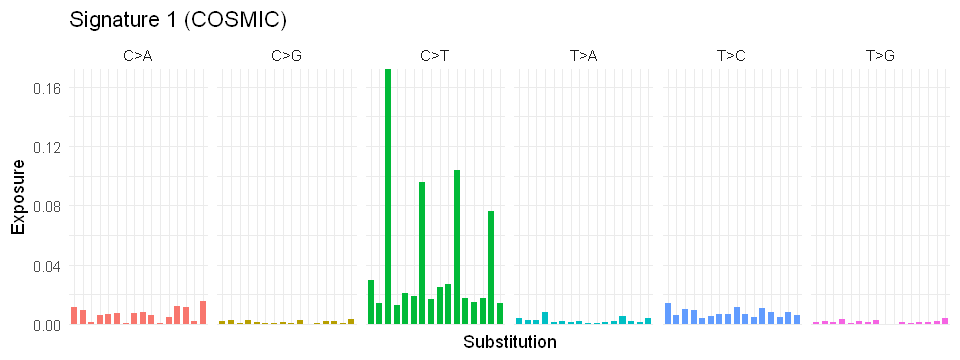

In [3]:
# Signature 1
signatures <- read.csv('data/signatures_probabilities.txt', sep="\t")
# Do some preformating for plot
signatures$Context <- paste(substr(signatures$Trinucleotide, 1, 1), substr(signatures$Trinucleotide, 3, 3), sep='')
ggplot(data=signatures, aes(x=Context, y=Signature.1)) +
    geom_bar(stat="identity", aes(fill=Substitution.Type), width=0.7) + facet_wrap(~ Substitution.Type, ncol=6) +
    xlab("Substitution") + ylab("Exposure") +  guides(fill=FALSE) + ggtitle("Signature 1 (COSMIC)") +
    theme_minimal() + theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) + scale_y_continuous(expand = c(0,0))

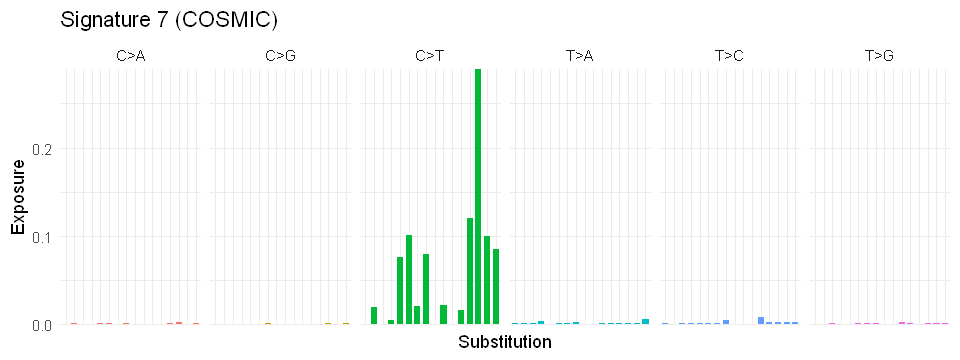

In [4]:
# Signature 7
ggplot(data=signatures, aes(x=Context, y=Signature.7)) +
    geom_bar(stat="identity", aes(fill=Substitution.Type), width=0.7) + facet_wrap(~ Substitution.Type, ncol=6) +
    xlab("Substitution") + ylab("Exposure") +  guides(fill=FALSE) + ggtitle("Signature 7 (COSMIC)") +
    theme_minimal() + theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) + scale_y_continuous(expand = c(0,0)) 

For each sample we estimated the the exposure $e_1$ to mutation signature 1 using a the R package desconstructSigs. The extraction follows the following procedure:

1. Select a biologically meaningful subset of $p$ mutation signatures (here, signatures 1, 5, 7, 11 and 17).
2. Normalize each component $m_i$ (=number of mutations of type $i$) by multiplying it with the proportion of occurences of the corresponding trinucleotide in the exome or genome. For example, if we denote by $q_i$ the proportion of trinucleotide $i$ (for example, TCG) occurs in a reference exome or genome, then we replace each entry $m_i$ of the catalog with $q_i m_i$, obtaining a new mutation catalog. 
3. Normalize the resulting catalog by dividing with the total number $m=\sum_{i=1}^K q_im_i$ of (normalized) mutations. This gives a new normalized mutation catalog $\tilde{\vct{m}}$ with the property that $\sum_{i=1}^K \tilde{m}_i = 1$. 
4. Solve a simplex-constrained least squares problem

\begin{equation*}
  \min_{\vct{\epsilon}\in \R^{p}} \left\|\tilde{\vct{m}}-\sum_{i=1}^p \epsilon_i \vct{p}_i\right\|_2^2 \text{ subject to } \epsilon_i\geq 0, 1\leq i\leq p, \text{ and } \sum_{i=1}^p \epsilon_i = 1.
\end{equation*}

The exposure to signature $j$ is then computed as $e_j = \epsilon_j \cdot \left(\sum_{i=1}^K q_i m_i\right)$. 

<font color="red">**TODO**</font> A few things need to be sorted out with respect to normalizations. I'm currently using the mutation counts provided with the data by Simon.

We added information on whether the sample had mutations in BRAF, NRAS, NF1 or none of these genes. 

<font color="red">**TODO**</font> Discuss how we classified double cases. For a subset of samples, additional information on the MC1R phenotype (whether an individual has two, one or no 'R' alleles) was included. This information was taken from the supplementary material of [Robles-Espinoza et al](http://www.nature.com/articles/ncomms12064).

<font color="red">**TODO**</font> Adjust numbers here.
The data was reduced by removing outliers. The idea here is that if a random variable $X$ is Poisson distributed with mean $\lambda$, then $2\sqrt{X}$ is approximately normally distributed with mean the median of $2\sqrt{X}$. We can then reject entries as outliers if the are bigger than the median $+3$. While this is a good approximation for large $\lambda$, it gives a conservative rule for rejecting outliers even for small $\lambda$.

The prepared data is summarized in a file 'tcga_4class.Rdata'. In addition, we computed means, robust means (based on robGlm) and medians for each age, and for each age restricted to the BRAF and NRAS samples.

<font color="red">**TODO**</font> Should we remove samples with 0 Sig1 or Sig7 mutations?

In [5]:
load('data/tcga_4class_new.Rdata')
data <- sigdata.tcga
cat("There are", dim(data)[1], "data samples\n")
load('data/tcga_4class.Rdata')

There are 396 data samples


#### Do a histogram of the frequency with which each total number of mutations occurs

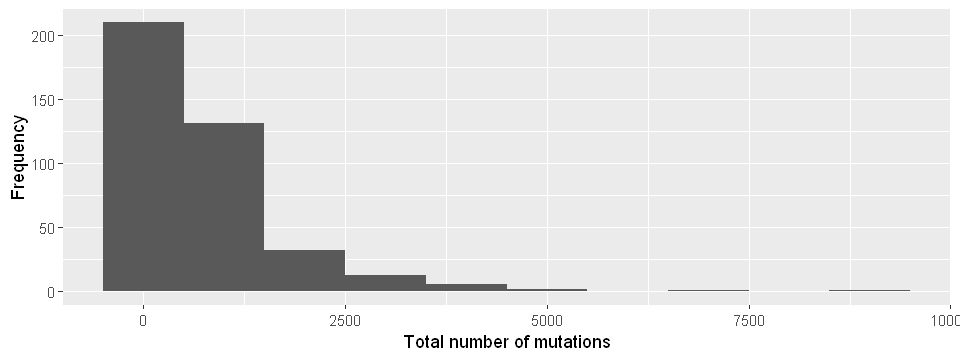

In [6]:
# Look out for outliers
ggplot(data=data, aes(data$TotalSNV)) + geom_histogram(binwidth=1000) +
    xlab("Total number of mutations") + ylab("Frequency")

In the above we see that a few samples exist with a massive amount of mutations. These will not bother us.

### <font color="grey">  1.1 Data summary</font>

#### We first summarize how many samples are in each category.

Explore the data and survey the different quantities (amount of samples with specific characteristics)

In [166]:
cat("TCGA data: \n")
cat("BRAF:", nrow(subset(data, Cohort=="BRAF")), "\n")
cat("NRAS:", nrow(subset(data, Cohort=="NRAS")), "\n")
cat("NF1:", nrow(subset(data, Cohort=="NF1")), "\n")
cat("Triple wild:", nrow(subset(data, Cohort=="W3")), "\n")
cat("Male BRAF:", nrow(subset(data, Cohort=="BRAF" & Gender=='MALE')), "\n")
cat("Male NRAS:", nrow(subset(data, Cohort=="NRAS" & Gender=='MALE')), "\n")
cat("Male NF1:", nrow(subset(data, Cohort=="NF1" & Gender=='MALE')), "\n")
cat("Male Triple wild:", nrow(subset(data, Cohort=="W3" & Gender=='MALE')), "\n")
cat("Female BRAF:", nrow(subset(data, Cohort=="BRAF" & Gender=='FEMALE')), "\n")
cat("Female NRAS:", nrow(subset(data, Cohort=="NRAS" & Gender=='FEMALE')), "\n")
cat("Female NF1:", nrow(subset(data, Cohort=="NF1" & Gender=='FEMALE')), "\n")
cat("Female Triple wild:", nrow(subset(data, Cohort=="W3" & Gender=='FEMALE')), "\n")
cat("MC1R information available for", nrow(subset(data, !is.na(MC1R))), "samples")

TCGA data: 
BRAF: 172 
NRAS: 96 
NF1: 44 
Triple wild: 84 
Male BRAF: 105 
Male NRAS: 61 
Male NF1: 29 
Male Triple wild: 51 
Female BRAF: 67 
Female NRAS: 35 
Female NF1: 15 
Female Triple wild: 33 
MC1R information available for 228 samples

The **averages** datasets below contain mean and median information on the number of mutations by each age group. This is because sometimes we want to analyse the median mutation load for each age against age.

In [8]:
averages <- read.csv('data/averages_new.csv', header=TRUE)
averages.brafnras <- read.csv('data/averages_brafnras_new.csv', header=TRUE)
averages.braf <- read.csv('data/averages_braf_new.csv', header=TRUE)
averages.nras <- read.csv('data/averages_nras_new.csv', header=TRUE)
averages.nf1 <- read.csv('data/averages_nf1_new.csv', header=TRUE)
averages.w3 <- read.csv('data/averages_w3_new.csv', header=TRUE)
averages.all <- read.csv('data/averages_all_new.csv', header=TRUE)
averages.male <- read.csv('data/averages_male_new.csv', header=TRUE)
averages.female <- read.csv('data/averages_female_new.csv', header=TRUE)
averages.gender <- read.csv('data/averages_gender_new.csv', header=TRUE)

#### Some overall statistics of the data
The conclusion from the below is that, on average, BRAF patients are younger than NRAS, which are much younger than NF1.

In [9]:
w3 <- subset(data, Cohort=="W3")$Age
nras <- subset(data, Cohort=="NRAS")$Age
braf <- subset(data, Cohort=="BRAF")$Age
nf1 <- subset(data, Cohort=="NF1")$Age
cat("Mean age for BRAF:", mean(braf), "\n")
cat("Mean age for NRAS:", mean(nras), "\n")
cat("Mean age for NF1:", mean(nf1), "\n")
cat("Mean age for W3:", mean(w3), "\n")
cat("Mean age overall:", mean(data$Age), "\n")

Mean age for BRAF: 52.77326 
Mean age for NRAS: 59.42708 
Mean age for NF1: 70.13636 
Mean age for W3: 62.90476 
Mean age overall: 58.46465 


Compute the average number of mutations (Signature 1 and total) for the whole dataset and for the subroups

In [10]:
w3 <- subset(data, Cohort=="W3")
nras <- subset(data, Cohort=="NRAS")
braf <- subset(data, Cohort=="BRAF")
nf1 <- subset(data, Cohort=="NF1")
cat("Sig1 for BRAF:", mean(braf$Sig1Total), "\n")
cat("Sig1 for NRAS:", mean(nras$Sig1Total), "\n")
cat("Sig1 for NF1:", mean(nf1$Sig1Total), "\n")
cat("Sig1 for W3:", mean(w3$Sig1Total), "\n")
cat("Sig1 overall:", mean(data$Sig1Total), "\n")
cat("Total for BRAF:", mean(braf$TotalSNV), "\n")
cat("Total for NRAS:", mean(nras$TotalSNV), "\n")
cat("Total for NF1:", mean(nf1$TotalSNV), "\n")
cat("Total for W3:", mean(w3$TotalSNV), "\n")
cat("Total overall:", mean(data$TotalSNV), "\n")

Sig1 for BRAF: 32.63372 
Sig1 for NRAS: 47.19792 
Sig1 for NF1: 70.02273 
Sig1 for W3: 32.30952 
Sig1 overall: 40.25 
Total for BRAF: 595.1744 
Total for NRAS: 843.7083 
Total for NF1: 1707.909 
Total for W3: 585.631 
Total overall: 777.0379 


These are just some auxiliary data sets that are used (or not) later throughout the analysis

In [11]:
# Auxiliary columns that might come handy
data$Sig1Ratio <- data$Sig1Total/data$Age
data$Sig1pSig7 <- data$Sig1Rel+data$Sig7Rel
data$range <- cut(data$Age, c(0, 30, 40, 50, 60, 70, 80, 90), include.lowest=FALSE)
data$two.range <- cut(data$Age, c(0, 55, 90), include.lowest=FALSE)
data$four.range <- cut(data$Age, c(0, 30, 50, 70, 90), include.lowest=FALSE)
averages.all$two.range <- cut(averages.all$Age, c(0, 55, 90), include.lowest=FALSE)
mysig7range <- cut(data$Sig7Total, seq(0,4000,by=10), include.lowest=FALSE)
a <- sapply(mysig7range, as.character)
data$sig7range <- unname(sapply(gsub(".*\\((.+)\\,.*", "\\1", a), as.numeric))

#### MC1R Information
Introduce new data frame (name: **mydata**) for samples with MC1R information.

In [12]:
# Add additional columns to the data
mydata <- subset(data, !is.na(MC1R))
mydata$Rallele <- as.factor(str_count(mydata$MC1R, 'R')>0)
levels(mydata$Rallele) <- c("0 R alleles", "1-2 R alleles")

In [13]:
cat("TCGA data (1-2 MC1R alleles): \n")
cat("BRAF:", nrow(subset(mydata, Cohort=="BRAF" & Rallele == "1-2 R alleles")), "\n")
cat("NRAS:", nrow(subset(mydata, Cohort=="NRAS" & Rallele == "1-2 R alleles")), "\n")
cat("NF1:", nrow(subset(mydata, Cohort=="NF1" & Rallele == "1-2 R alleles")), "\n")
cat("Triple wild:", nrow(subset(mydata, Cohort=="W3" & Rallele == "1-2 R alleles")), "\n")

TCGA data (1-2 MC1R alleles): 
BRAF: 55 
NRAS: 25 
NF1: 16 
Triple wild: 18 


In [14]:
cat("TCGA data (0 MC1R alleles): \n")
cat("BRAF:", nrow(subset(mydata, Cohort=="BRAF" & Rallele == "0 R alleles")), "\n")
cat("NRAS:", nrow(subset(mydata, Cohort=="NRAS" & Rallele == "0 R alleles")), "\n")
cat("NF1:", nrow(subset(mydata, Cohort=="NF1" & Rallele == "0 R alleles")), "\n")
cat("Triple wild:", nrow(subset(mydata, Cohort=="W3" & Rallele == "0 R alleles")), "\n")

TCGA data (0 MC1R alleles): 
BRAF: 41 
NRAS: 35 
NF1: 14 
Triple wild: 24 


In [15]:
# For later use
sigs <- c("Sig1Med", "Sig7Med")
sigst <- c("Sig1Total", "Sig7Total")
cohorts <- c("BRAF", "NRAS", "NF1", "W3")
alleles <- c("0 R alleles", "1-2 R alleles")
genders <- c("MALE", "FEMALE")
avgsets <- list(averages.braf, averages.nras, averages.nf1, averages.w3)
cohortsets <- list(subset(data, Cohort=='BRAF'),subset(data, Cohort=='NRAS'),subset(data, Cohort=='NF1'),subset(data, Cohort=='W3'))
sig7ranges <- sort(unique(data$sig7range)[!is.na(unique(data$sig7range))])

###  <a id='chapter2'><font color="grey">  2. The molecular subtypes of melanoma present distinct ratios of clock-like mutations per unit of time</font></a>

Robust linear regression of Signature 1 against age, and subdivided by cohorts.

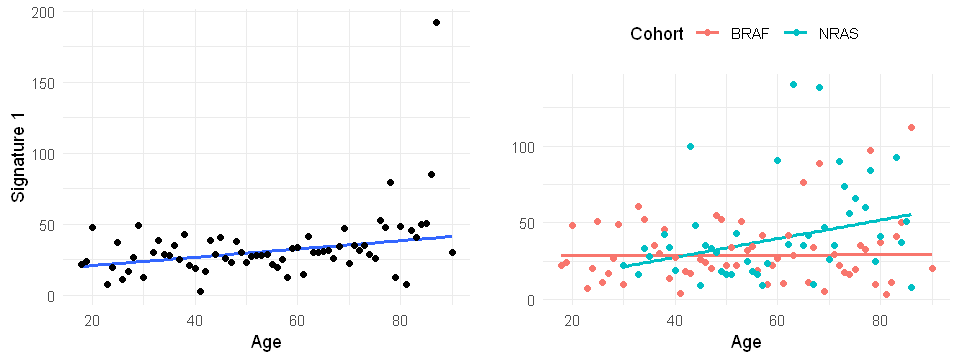

In [16]:
plot1 <- ggplot(averages, aes(Age, Sig1Med)) +  geom_smooth(method = "rlm", se=FALSE) + geom_point() +
    xlab("Age") + ylab("Signature 1") + theme_minimal()# + theme(legend.position="none")
plot2 <- ggplot(subset(averages.all, Cohort=='BRAF' | Cohort=='NRAS'), aes(Age, Sig1Med, color=Cohort)) +  geom_smooth(method = "rlm", se=FALSE) + geom_point() +
    xlab("Age") + ylab("") +#scale_y_continuous(limits = c(0,2000)) +
    theme_minimal() + theme(legend.position="top")
grid.arrange(plot1, plot2, ncol=2)
p <- arrangeGrob(plot1, plot2, ncol=2)

In [17]:
ggsave("./figures/Figure1AB.pdf", p, scale=1, width=8, height=3)

#### Robust linear regression coefficients with P-value

In [18]:
res <- rlm(as.formula("Sig1Med ~ Age"), data=averages)
p.slope <- f.robftest(res, var = "Age")$p.value
p.intercept <- f.robftest(res, var = "(Intercept)")$p.value
cat("(Signature 1)", " Slope on robust regression:", unname(coef(res)['Age']), "with P-value", p.slope, "\n")
cat("(Signature 1)", " Intercept on robust regression:", unname(coef(res)['(Intercept)']), "with P-value", p.intercept, "\n\n")
for (i in seq(1:4)) {
    res <- rlm(as.formula("Sig1Med ~ Age"), data=avgsets[[i]])
    p.slope <- f.robftest(res, var = "Age")$p.value
    p.intercept <- f.robftest(res, var = "(Intercept)")$p.value
    cat("(Signature 1", cohorts[i],")", " Slope on robust regression:", unname(coef(res)['Age']), "with P-value", p.slope, "\n")
    cat("(Signature 1", cohorts[i],")", " Intercept on robust regression:", unname(coef(res)['(Intercept)']), "with P-value", p.intercept, "\n\n")
}

(Signature 1)  Slope on robust regression: 0.291665 with P-value 0.0001962111 
(Signature 1)  Intercept on robust regression: 15.19152 with P-value 0.0005750235 

(Signature 1 BRAF )  Slope on robust regression: 0.008617164 with P-value 0.9415698 
(Signature 1 BRAF )  Intercept on robust regression: 28.42844 with P-value 6.311321e-05 

(Signature 1 NRAS )  Slope on robust regression: 0.6088802 with P-value 0.01281734 
(Signature 1 NRAS )  Intercept on robust regression: 3.121746 with P-value 0.8280754 

(Signature 1 NF1 )  Slope on robust regression: -0.3813987 with P-value 0.541845 
(Signature 1 NF1 )  Intercept on robust regression: 88.86857 with P-value 0.04871418 

(Signature 1 W3 )  Slope on robust regression: 0.3594969 with P-value 0.01420938 
(Signature 1 W3 )  Intercept on robust regression: 0.4584079 with P-value 0.9585655 



#### Spearman rho

In [19]:
# Compute confidence intervals by bootstrapping
spearman.rho.sig1med.age <- function(data, indices) {
  d <- data[indices,] # allows boot to select sample 
  fit <- cor.test(d$Age, d$Sig1Med, method="spearman", alternative="greater", data=d, exact=FALSE)
  return(fit$estimate)
} 

In [20]:
correlation <- cor.test(averages$Age, averages$Sig1Med, method="spearman", alternative="greater", exact=FALSE)
cat("Spearman correlation with age on complete dataset:", correlation$estimate, "with P-value", correlation$p.value, "\n\n")
for (i in seq(1:4)) {
    correlation <- cor.test(avgsets[[i]]$Age, avgsets[[i]]$Sig1Med, method="spearman", alternative="greater", exact=FALSE)
    cat("Spearman rho correlation with age on", cohorts[i], "dataset:", correlation$estimate, "with P-value", correlation$p.value, "\n")
    }

Spearman correlation with age on complete dataset: 0.4057697 with P-value 0.0002984914 

Spearman rho correlation with age on BRAF dataset: 0.02965413 with P-value 0.4102645 
Spearman rho correlation with age on NRAS dataset: 0.3504566 with P-value 0.009843771 
Spearman rho correlation with age on NF1 dataset: -0.1034738 with P-value 0.7033811 
Spearman rho correlation with age on W3 dataset: 0.3650716 with P-value 0.0080393 


#### Median Signature 1/age by cohorts

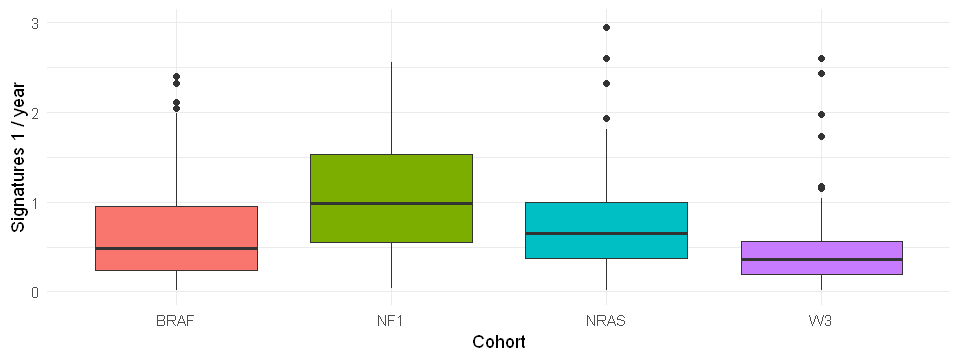

In [21]:
plot1 <- ggplot(data, aes(Cohort, (Sig1Total)/Age, fill=Cohort)) +
    geom_boxplot() + ylab("Signatures 1 / year") + theme_minimal() + guides(fill=FALSE) + coord_cartesian(ylim = c(0,3))
grid.arrange(plot1, ncol=1)
p <- arrangeGrob(plot1, ncol=1)

In [22]:
ggsave("./figures/Figure1C.pdf", p, scale=1, width=8, height=4)

In [23]:
md.sig1sig7 <- function(data, indices) {
    mydata <- data[indices,]
    return(median((mydata$Sig1Total)/mydata$Age))
}

In [24]:
for (i in seq(1:4)) {
    res <- md.sig1sig7(subset(data, Cohort==cohorts[i]),)
    cat("Median ratio for", cohorts[i], ": ", res, "\n\n")
}

Median ratio for BRAF :  0.4827761 

Median ratio for NRAS :  0.648099 

Median ratio for NF1 :  0.9872416 

Median ratio for W3 :  0.3566536 



#### Mann-Whitney U test with Bonferroni correction
Test whether the ratios Sig1/Age differ in median across the subtypes. Using Sig1+Sig7, otherwise not significant difference between BRAF and NRAS.

In [25]:
# Do a two-sided Wilcoxon test
newdata <- data
pwres <- pairwise.wilcox.test((newdata$Sig1Total)/newdata$Age, newdata$Cohort, exact=FALSE, paired=FALSE, alternative="two.sided", p.adj="bonferroni")
pwres$p.value

,BRAF,NF1,NRAS
NF1,0.008076785,NA,NA
NRAS,0.365750940,2.081495e-01,NA
W3,0.024275375,5.093829e-05,5.324416e-05


In [26]:
# Only compare BRAF and NRAS
md.sig1 <- function(data, indices) {
    mydata <- data[indices,]
    return(median(mydata$Sig1Total/mydata$Age))
}

In [27]:
newdata.braf <- subset(data, Cohort=='BRAF')
newdata.nras <- subset(data, Cohort=='NRAS')
pwres <- wilcox.test(newdata.braf$Sig1Total/newdata.braf$Age, newdata.nras$Sig1Total/newdata.nras$Age, alternative="two.sided", exact=FALSE, pairwise=FALSE)
cat("P-value for BRAF vs NRAS:", pwres$p.value, '\n')

P-value for BRAF vs NRAS: 0.06095849 


#### Test the difference in the presence of 0 or 1-2 MC1R R alleles

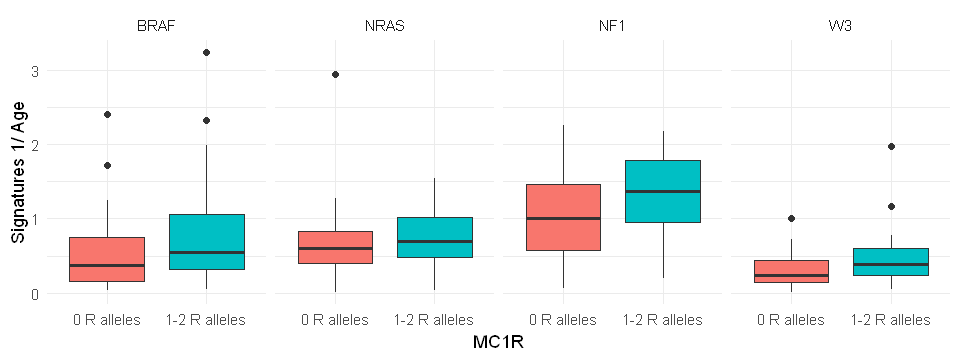

In [38]:
p <- ggplot(transform(mydata,
      Cohort=factor(Cohort,levels=c("BRAF","NRAS","NF1","W3"))), aes(Rallele, Sig1Total/Age, fill=Rallele)) +
    geom_boxplot() + ylab("Signatures 1/ Age") + theme_minimal() + #coord_cartesian(ylim = c(0,55)) + 
    guides(fill=FALSE) + facet_wrap(~ Cohort, ncol=4) + xlab("MC1R")
grid.arrange(p, ncol=1)

In [39]:
ggsave("./figures/SupFigure1.pdf", p, scale=1, width=8, height=4)

#### Wilcoxon rank-sum test to see whether the ratios Sig1/Age differ depending on MC1R status

In [30]:
newdataR <- subset(mydata, Rallele=='1-2 R alleles')
newdata0 <- subset(mydata, Rallele=='0 R alleles')
medR <- median(newdataR$Sig1Total/newdataR$Age)
med0 <- median(newdata0$Sig1Total/newdata0$Age)
cat("Median ratio: ", medR/med0, "\n\n")
pwres <- wilcox.test(newdataR$Sig1Total/newdataR$Age, newdata0$Sig1Total/newdata0$Age, paired=FALSE, exact=FALSE)
cat("P-value:", pwres$p.value, '\n')

Median ratio:  1.406727 

P-value: 0.005012568 


#### Confidence interval via bootstrapping

In [48]:
md <- function(data, indices) {
    tempdata <- data[indices,]
    return(median(subset(tempdata, Rallele=='1-2 R alleles')$Sig1Ratio/median(subset(tempdata, Rallele=='0 R alleles')$Sig1Ratio)))
}
bootmed.all <- boot(data=mydata, statistic=md, R=10000)
boot.ci(bootmed.all)

Warning message in boot.ci(bootmed.all):
"bootstrap variances needed for studentized intervals"

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 10000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootmed.all)

Intervals : 
Level      Normal              Basic         
95%   ( 0.905,  1.818 )   ( 0.775,  1.818 )  

Level     Percentile            BCa          
95%   ( 0.996,  2.038 )   ( 0.925,  1.880 )  
Calculations and Intervals on Original Scale

In [49]:
for (i in seq(1:4)) {
    newdataR <- subset(mydata, Cohort==cohorts[i] & Rallele=='1-2 R alleles')
    newdata0 <- subset(mydata, Cohort==cohorts[i] & Rallele=='0 R alleles')
    medR <- median(newdataR$Sig1Total/newdataR$Age)
    med0 <- median(newdata0$Sig1Total/newdata0$Age)
    cat("Median ratio: ", medR/med0, "\n")
    pwres <- wilcox.test(newdataR$Sig1Total/newdataR$Age, newdata0$Sig1Total/newdata0$Age, paired=FALSE, exact=FALSE)
    cat("P-value for", cohorts[i], ":", pwres$p.value, '\n')
}

Median ratio:  1.462795 
P-value for BRAF : 0.02504957 
Median ratio:  1.170213 
P-value for NRAS : 0.4763152 
Median ratio:  1.362108 
P-value for NF1 : 0.1903744 
Median ratio:  1.567422 
P-value for W3 : 0.1121673 


###  <a id='chapter3'><font color="grey">  3. Aging affects the intrinsic mutation rate of the molecular subtypes.</font></a>

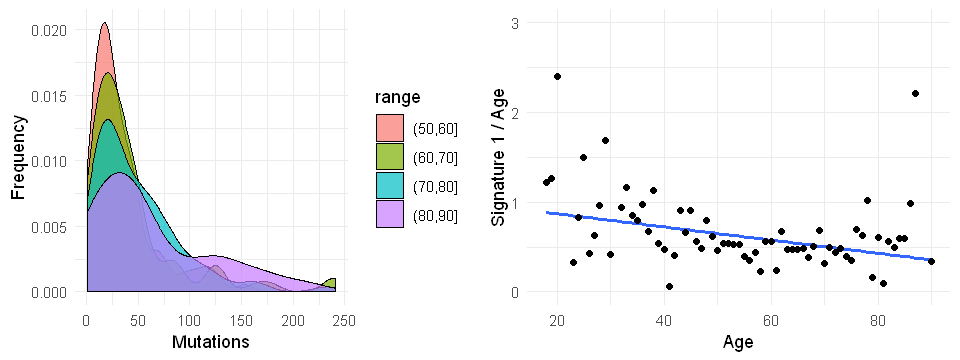

In [50]:
plot1 <- ggplot(subset(data, range != "(0,30]" & range != "(40,50]" & range != "(30,40]"), aes(x=Sig1Total, fill=range)) +
    geom_density(alpha=0.7) + theme_minimal() + xlab("Mutations") + ylab("Frequency")
plot2 <- ggplot(averages, aes(Age, Sig1Med/Age)) +  geom_smooth(method = "rlm", se=FALSE) + geom_point() +
    xlab("Age") + ylab("Signature 1 / Age") + theme_minimal() + theme(legend.position="none") + coord_cartesian(ylim = c(0,3))
grid.arrange(plot1, plot2, ncol=2)
p <- arrangeGrob(plot1, plot2, ncol=2)

In [51]:
ggsave("./figures/Figure2AB.pdf", plot=p, scale=1, width=8, height=4)

#### Spearman rho of Sig1/Age against age

In [52]:
sig1ageagecor <- cor.test(averages$Sig1Med/averages$Age, averages$Age, method="spearman", alternative="two.sided", exact=FALSE)
cat("Spearman correlation between Sig1/Age and Age:", sig1ageagecor$estimate, "with P-value", sig1ageagecor$p.value, "\n")

Spearman correlation between Sig1/Age and Age: -0.3362822 with P-value 0.005050457 


#### Test Spearman rho correlation across subtypes

In [53]:
sig1ageagecor.braf <- cor.test(averages.braf$Sig1Med/averages.braf$Age, averages.braf$Age, method="spearman", alternative="two.sided", exact=FALSE)
cat("Spearman correlation between Sig1/Age and Age for BRAF:", sig1ageagecor.braf$estimate, "with P-value", sig1ageagecor.braf$p.value, "\n")
sig1ageagecor.nras <- cor.test(averages.nras$Sig1Med/averages.nras$Age, averages.nras$Age, method="spearman", alternative="two.sided", exact=FALSE)
cat("Spearman correlation between Sig1/Age and Age for NRAS:", sig1ageagecor.nras$estimate, "with P-value", sig1ageagecor.nras$p.value, "\n")
sig1ageagecor.w3 <- cor.test(averages.w3$Sig1Med/averages.w3$Age, averages.w3$Age, method="spearman", alternative="two.sided", exact=FALSE)
cat("Spearman correlation between Sig1/Age and Age for NRAS:", sig1ageagecor.w3$estimate, "with P-value", sig1ageagecor.w3$p.value, "\n")

Spearman correlation between Sig1/Age and Age for BRAF: -0.4376578 with P-value 0.0004199746 
Spearman correlation between Sig1/Age and Age for NRAS: -0.08005638 with P-value 0.6054516 
Spearman correlation between Sig1/Age and Age for NRAS: 0.0114769 with P-value 0.9417713 


### <font color="grey">  Intermezzo: the model.</font>

In order to more accurately quantify the accumulation of mutations over time, we need to make some model assumptions. While these assumptions may represent oversimplifications, they lead to systematic biases that would hold across different cohorts, and still allow to compare properties of the different types of samples to each other.

For the accumulation of mutations at time $t$, [Podolskiy et al](http://www.nature.com/articles/ncomms12157) postulate the following model, assumed to be valid for a certain age range. At each age $t$, the number of muations $N(t)$ is approximately distributed according to a Poisson distribution with rate $\lambda(t)$,

\begin{equation*}
  \mtx{P}\{N(t) = n\} = \frac{\lambda(t)^n e^{-\lambda(t)}}{n!}.
\end{equation*}

While [Podolskiy et al](http://www.nature.com/articles/ncomms12157) consider the total number of mutations and argue statistically via the law of large numbers, it is reasonable to assume that the accumulation of units of signature 1 also follows a Poisson-like distribution, or a mixture of Poisson distributions with one dominant component. This component is assumed to describe the accumulation of mutations before clonal expansion, after which the dynamics change. 

**TODO** Estimate number of drivers by fitting a Poisson mixture model. May need more data / pan-cancer data for this and/or use a Bayesian approach. Topic for another paper.

Suppose that at age $t$ we have $N_1(t),\dots,N_s(t)$ samples. We estimate the parameter $\lambda(t) = \lambda(t,X_1,\dots,X_p) = \mtx{E}[N(t) \ | \ X_1,\dots,X_p]$ using Poisson regression,

\begin{equation*}
  \log \mtx{E}[N(t) \ | \ X_1,\dots,X_p ] = \beta_0 + \sum_{i=1}^p \beta_i X_i,
\end{equation*}

where the $\beta_i$ are allowed to depend on $t$. In [Podolskiy et al](http://www.nature.com/articles/ncomms12157), the authors look at small time intervals and determine the Poisson peaks for each of these intervals. 
The practical problem with the approach described above is that we do not have enough data for reliably estimating Poisson average at each time. We can still try to use, for eath $t$ in a suitable range and $\Delta t$ (for example, 5 years), to use the interval $(t-\Delta t, t+\Delta t]$. A different approach would be to estimate the parameters for all times simultaneously.

Under simplifying assumptions, we can just include age (time) $t$ among the dependent variables and solve a standard Poisson model,

\begin{equation*}
  \log \mtx{E}[N \ | \ t, X_1,\dots,X_p ] = \beta_0 + \alpha t + \sum_{i=1}^p \beta_i X_i,
\end{equation*}

We first try to incorporate as many covariates as possible in the model.

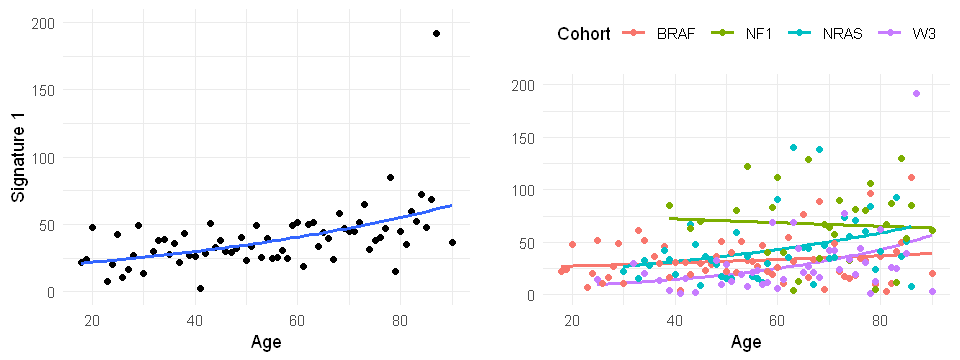

In [55]:
plot1 <- ggplot(averages, aes(Age, Sig1Mean)) +  geom_point() +
    geom_smooth(method = "glm", aes(Age, as.integer(Sig1Mean)), formula = y ~ x, data=averages, se=FALSE, method.args = (family="poisson")) +
    xlab("Age") + ylab("Signature 1") + theme_minimal() + coord_cartesian(ylim = c(0,200))# + theme(legend.position="none")
plot2 <- ggplot(averages.all, aes(Age, Sig1Mean, color=Cohort)) +  
    geom_smooth(method = "glm", aes(Age, as.integer(Sig1Mean)), formula = y ~ x, data=averages.all, se=FALSE, method.args = (family="poisson")) + 
    geom_point() + xlab("Age") + ylab("") + theme_minimal() + theme(legend.position="top") + coord_cartesian(ylim = c(0,200))
p <- arrangeGrob(plot1, plot2, ncol=2)
grid.arrange(plot1, plot2, ncol=2)

In [56]:
ggsave("./figures/Figure2CD.pdf", plot=p, scale=1, width=8, height=3)

In the model above, we use the formula $N(t)=N_0e^{\alpha t}$ to model the accumulation of Signature 1 mutations. We estimate the parameters $\alpha$ and $N_0$ of this model using negative binomial regression. A standard algebraic computation shows that the we should expect a decrease in the ratio of mutations $N/t$ for ages $t<1/\alpha$ and an increase for ages $t>1/\alpha$. We compute the critical age threshold below.

In [65]:
res <- glm.nb(as.integer(Sig1Med) ~ Age, data=averages)
alpha <- coef(res)["Age"]
cat("alpha: ", alpha, "Inverse of alpha: ", 1/alpha, "\n\n")
res.braf <- glm.nb(as.integer(Sig1Med) ~ Age, data=averages.braf)
alpha.braf <- coef(res.braf)["Age"]
cat("alpha for BRAF: ", alpha.braf, "Inverse of alpha: ", 1/alpha.braf, "\n")
res.nras <- glm.nb(as.integer(Sig1Med) ~ Age, data=averages.nras)
alpha.nras <- coef(res.nras)["Age"]
cat("alpha for NRAS: ", alpha.nras, "Inverse of alpha: ", 1/alpha.nras, "\n")
res.w3 <- glm.nb(as.integer(Sig1Med) ~ Age, data=averages.w3)
alpha.w3 <- coef(res.w3)["Age"]
cat("alpha for W3: ", alpha.w3, "Inverse of alpha: ", 1/alpha.w3)

alpha:  0.01233727 Inverse of alpha:  81.05518 

alpha for BRAF:  0.004725981 Inverse of alpha:  211.5963 
alpha for NRAS:  0.01537201 Inverse of alpha:  65.05332 
alpha for W3:  0.02344969 Inverse of alpha:  42.64449

Get confidence intervals and P values

In [102]:
alpha <- function(data, indices) {
  d <- data[indices,] # allows boot to select sample 
  res <- glm.nb(as.integer(d$Sig1Total) ~ d$Age, data = d)
  return(1/unname(coef(res)["d$Age"]))
} 
results <- boot(data=data, statistic=alpha, R=1000)
boot.ci(results, type="basic")
results.braf <- boot(data=subset(data, Cohort=='BRAF'), statistic=alpha, R=1000)
boot.ci(results.braf, type="basic")
results.nras <- boot(data=subset(data, Cohort=='NRAS'), statistic=alpha, R=1000)
boot.ci(results.nras, type="basic")
results.w3 <- boot(data=subset(data, Cohort=='W3'), statistic=alpha, R=1000)
boot.ci(results.w3, type="basic")

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "basic")

Intervals : 
Level      Basic         
95%   (25.02, 95.06 )  
Calculations and Intervals on Original Scale

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = results.braf, type = "basic")

Intervals : 
Level      Basic         
95%   (-2118.3,  2136.5 )  
Calculations and Intervals on Original Scale

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = results.nras, type = "basic")

Intervals : 
Level      Basic         
95%   (-99.89, 100.60 )  
Calculations and Intervals on Original Scale

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = results.w3, type = "basic")

Intervals : 
Level      Basic         
95%   (-13.71,  50.74 )  
Calculations and Intervals on Original Scale

We next fit the curves $N_0e^{\alpha t}$ with the estimated parameters to the data.

In [103]:
expfun.braf <- function(x) {
    return(unname(exp(coef(res.braf)["(Intercept)"]))*exp(unname(coef(res.braf)["Age"])*x)/x)
    }
expfun.nras <- function(x) {
    return(exp(unname(coef(res.nras)["(Intercept)"]))*exp(unname(coef(res.nras)["Age"])*x)/x)
    }
expfun.w3 <- function(x) {
    return(exp(unname(coef(res.w3)["(Intercept)"]))*exp(unname(coef(res.w3)["Age"])*x)/x)
    }

In [104]:
line.braf <- data.frame(x = seq(20,90, by=0.1), y=sapply(seq(20,90, by=0.1), expfun.braf))
line.nras <- data.frame(x = seq(30,90, by=0.1), y=sapply(seq(30,90, by=0.1), expfun.nras))
line.w3 <- data.frame(x = seq(30,90, by=0.1), y=sapply(seq(30,90, by=0.1), expfun.w3))

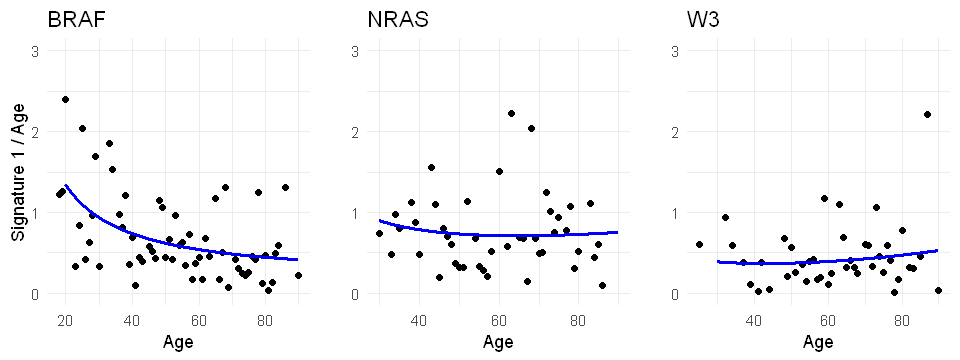

In [106]:
plot1 <- ggplot(averages.braf, aes(Age, Sig1Med/Age)) + geom_point() +
    xlab("Age") + ylab("Signature 1 / Age") + theme_minimal() + theme(legend.position="none") + ggtitle('BRAF') + coord_cartesian(ylim = c(0,3))+ geom_line(data=line.braf, aes(x, y), color="blue", size=1)
plot2 <- ggplot(averages.nras, aes(Age, Sig1Mean/Age)) + geom_point() +
    xlab("Age") + ylab("") + theme_minimal() + theme(legend.position="none") + ggtitle('NRAS') + coord_cartesian(ylim = c(0,3))+ geom_line(data=line.nras, aes(x, y), color="blue", size=1)
plot3 <- ggplot(averages.w3, aes(Age, Sig1Mean/Age)) + geom_point() +
    xlab("Age") + ylab("") + theme_minimal() + theme(legend.position="none") + ggtitle('W3') + coord_cartesian(ylim = c(0,3))+ geom_line(data=line.w3, aes(x, y), color="blue", size=1)
grid.arrange(plot1, plot2, plot3, ncol=3, nrow=1)
p <- arrangeGrob(plot1, plot2, plot3, ncol=3, nrow=1)

In [107]:
ggsave("./figures/Figure2E.pdf", plot=p, scale=1, width=8, height=3)

**Todo** P-values and confidence intervals

###  <a id='chapter4'><font color="grey">  4. Signature 1 and signature 7 mutations are tightly correlated and together contribute to melanoma across all molecular subtypes.  </font></a>

In [108]:
# Compute averages of relative contribution of sig 1 and sig 7
nosig.braf <- 1-mean(subset(data, Cohort=='BRAF')$Sig1pSig7)
nosig.nras <- 1-mean(subset(data, Cohort=='NRAS')$Sig1pSig7)
nosig.nf1 <- 1-mean(subset(data, Cohort=='NF1')$Sig1pSig7)
nosig.w3 <- 1-mean(subset(data, Cohort=='W3')$Sig1pSig7)
sig7.braf <- mean(subset(data, Cohort=='BRAF')$Sig7Rel)
sig7.nras <- mean(subset(data, Cohort=='NRAS')$Sig7Rel)
sig7.nf1 <- mean(subset(data, Cohort=='NF1')$Sig7Rel)
sig7.w3 <- mean(subset(data, Cohort=='W3')$Sig7Rel)
sig1.braf <- mean(subset(data, Cohort=='BRAF')$Sig1Rel)
sig1.nras <- mean(subset(data, Cohort=='NRAS')$Sig1Rel)
sig1.nf1 <- mean(subset(data, Cohort=='NF1')$Sig1Rel)
sig1.w3 <- mean(subset(data, Cohort=='W3')$Sig1Rel) 

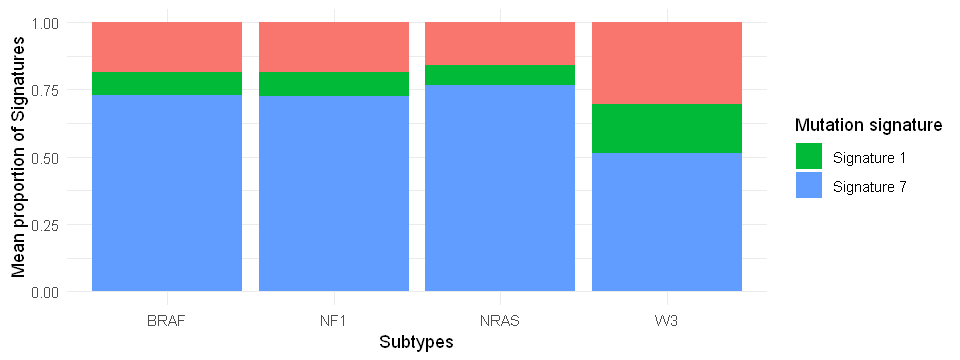

In [115]:
proportions <- c(sig1.braf, sig1.nras, sig1.nf1, sig1.w3, 
                 sig7.braf, sig7.nras, sig7.nf1, sig7.w3, 
                 nosig.braf, nosig.nras, nosig.nf1, nosig.w3)
labels <- c(rep(c('BRAF','NRAS','NF1','W3'),3))
types <- c(rep("Sig1",4), rep("Sig7",4), rep("Nosig",4))
newdata <- data.frame(labels, proportions, types)
p <- ggplot(data=newdata[order(newdata$types),], aes(labels, proportions, fill=types)) + geom_bar(stat = "identity") + 
    xlab("Subtypes") + ylab("Mean proportion of Signatures") + theme_minimal() + 
    scale_fill_discrete(name="Mutation signature", breaks=c("Sig1","Sig7",'Rest'), labels=c("Signature 1", "Signature 7", "Rest"))
grid.arrange(p)

In [116]:
ggsave("./figures/Figure3A.pdf", plot=p, scale=1, width=8, height=3)

Plot Signature 1 against Signature 7

In [111]:
# Compute median sig1 for each sig7
averages.sig7 <- data.frame(Sig7Total=sig7ranges)
averages.sig7$Sig1Med <- NA
for (s in sig7ranges) {
  i <- match(s,averages.sig7$Sig7Total)
  averages.sig7[i,c("Sig1Med")] <- median(data[which(data$sig7range==s),"Sig1Total"])
}
# Compute median sig1 for each sig7 subdivided by cohorts
averages.sig7.cohort <- data.frame(Sig7Total=integer(), Sig1Med=double(), Cohort=character())
for (j in seq(4)) {
    sig7 <- sort(unique(subset(data,Cohort==cohorts[j])$sig7range)[!is.na(unique(subset(data,Cohort==cohorts[j])$sig7range))])
    averages.temp <- data.frame(Sig7Total=sig7, Sig1Med=as.double(NA))
    for (s in sig7) {
        i <- match(s,averages.temp$Sig7Total)
        averages.temp[i,c("Sig1Med")] <- median(data[which(data$sig7range==s & data$Cohort==cohorts[j]),"Sig1Total"])
        }
    averages.temp$Cohort <- cohorts[j]
    averages.sig7.cohort <- rbind(averages.sig7.cohort, averages.temp)
    }

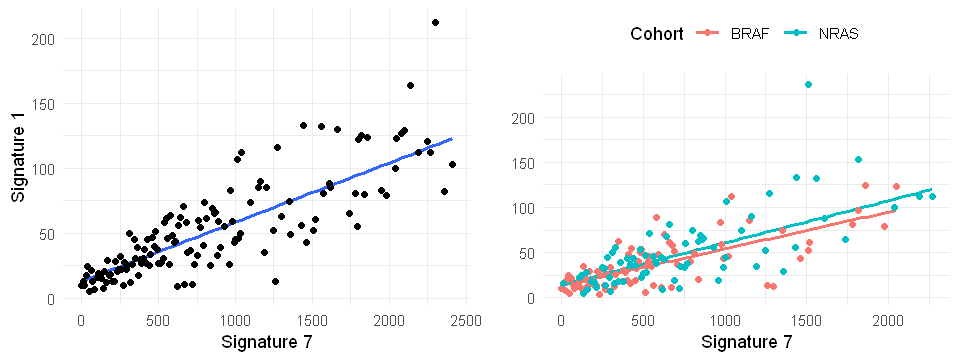

In [123]:
plot1 <- ggplot(subset(averages.sig7, Sig7Total<2500), aes(Sig7Total, Sig1Med)) +  geom_smooth(method = "rlm", se=FALSE) + geom_point() +
    xlab("Signature 7") + ylab("Signature 1") + theme_minimal()# + theme(legend.position="none")
plot2 <- ggplot(subset(averages.sig7.cohort, (Cohort=='BRAF' | Cohort=='NRAS') & Sig7Total<2500), aes(Sig7Total, Sig1Med, color=Cohort)) +  geom_smooth(method = "rlm", se=FALSE) + geom_point() +
    xlab("Signature 7") + ylab("") +# scale_y_continuous(limits = c(0,2000)) +
    theme_minimal() + theme(legend.position="top")
grid.arrange(plot1, plot2, ncol=2)
p <- arrangeGrob(plot1, plot2, ncol=2)

In [124]:
ggsave("./figures/Figure3BC.pdf", plot=p, scale=1, width=8, height=4)

#### Robust regression

In [125]:
res<-rlm(Sig1Med ~ Sig7Total, data=averages.sig7)
slope.total <- unname(coef(res)['Sig7Total'])
p1.total <- f.robftest(res, var = "Sig7Total")$p.value
cat("(Total) Slope on robust regression:", slope.total, "with P-value", p1.total, "\n")

(Total) Slope on robust regression: 0.03940908 with P-value 2.256961e-39 


#### Spearman rho correlation

In [126]:
sig1sig7cor <- cor.test(averages.sig7$Sig7Total, averages.sig7$Sig1Med, method="spearman", alternative="two.sided", exact=FALSE)
cat("Spearman correlation between Signature 1 and Signature 7:", sig1sig7cor$estimate, "with P-value", sig1sig7cor$p.value, "\n")

Spearman correlation between Signature 1 and Signature 7: 0.8157706 with P-value 2.678654e-36 


#### Spearman rho across subtypes

In [127]:
# Determine slope and intersept with corresponding P values for robust linear regression on all the data
cat("Spearman rho correlation between Signature 1 and Signature 7\n\n")
for (i in seq(1:4)) {
    sig1sig7cor <- cor.test(subset(averages.sig7.cohort, Cohort==cohorts[i])$Sig7Total, subset(averages.sig7.cohort, Cohort==cohorts[i])$Sig1Med, method="spearman", alternative="two.sided", exact=FALSE)
    cat("(", cohorts[i], ")", "Spearman correlation between Signature 1 and Signature 7:", sig1sig7cor$estimate, "with P-value", sig1sig7cor$p.value, "\n")
}

Spearman rho correlation between Signature 1 and Signature 7

( BRAF ) Spearman correlation between Signature 1 and Signature 7: 0.7026673 with P-value 1.322763e-13 
( NRAS ) Spearman correlation between Signature 1 and Signature 7: 0.719397 with P-value 1.577996e-12 
( NF1 ) Spearman correlation between Signature 1 and Signature 7: 0.7970862 with P-value 1.004728e-08 
( W3 ) Spearman correlation between Signature 1 and Signature 7: 0.642682 with P-value 3.37293e-06 


#### Mann-Whitney U test for ratio Sig1/Sig7 across subtypes

In [128]:
# Do a two-sided Wilcoxon test
newdata <- subset(data, Sig7Total>0)
pwres <- pairwise.wilcox.test(newdata$Sig1Total/newdata$Sig7Total, newdata$Cohort, exact=FALSE, p.adj="bonferroni")
pwres$p.value

,BRAF,NF1,NRAS
NF1,0.1102664,NA,NA
NRAS,0.5293460,0.68916816,NA
W3,1.0000000,0.08695743,0.502788


#### Wilcoxon rank-sum test for ratio Sig1/Sig7 for BRAF and NRAS

In [129]:
# Only compare BRAF and NRAS
newdata.braf <- subset(data, Cohort=='BRAF' & Sig7Total>0)
newdata.nras <- subset(data, Cohort=='NRAS' & Sig7Total>0)
pwres <- wilcox.test(newdata.braf$Sig1Total/newdata.braf$Sig7Total, newdata.nras$Sig1Total/newdata.nras$Sig7Total, exact=FALSE, pairwise=FALSE)
cat("P-value for BRAF vs NRAS:", pwres$p.value, '\n')

P-value for BRAF vs NRAS: 0.08822434 


#### Effect of MC1R

In [130]:
# Determine slope and intersept with corresponding P values for robust linear regression on all the data
cat("Spearman rho correlation between Signature 1 and Signature 7\n\n")
for (i in seq(1:2)) {
    sig1sig7cor <- cor.test(subset(mydata, Rallele==alleles[i])$Sig7Total, subset(mydata, Rallele==alleles[i])$Sig1Total, method="spearman", alternative="two.sided", exact=FALSE)
    cat("(", alleles[i], ")", "Spearman correlation between Signature 1 and Signature 7:", sig1sig7cor$estimate, "with P-value", sig1sig7cor$p.value, "\n")
}

Spearman rho correlation between Signature 1 and Signature 7

( 0 R alleles ) Spearman correlation between Signature 1 and Signature 7: 0.7553396 with P-value 2.749074e-22 
( 1-2 R alleles ) Spearman correlation between Signature 1 and Signature 7: 0.7429028 with P-value 3.013988e-21 


#### Effect of Gender

In [131]:
# Compute averages in separate data frame (MALE)
sig7male <- sort(unique(subset(data,Gender=="MALE")$sig7range)[!is.na(unique(subset(data,Gender=="MALE")$sig7range))])
averages.male.sig7 <- data.frame(Sig7Total=sig7male)
averages.male.sig7$Sig1Med <- NA
for (s in sig7male) {
  i <- match(s,averages.male.sig7$Sig7Total)
  averages.male.sig7[i,c("Sig1Med")] <- median(data[which(data$sig7range==s & data$Gender=="MALE"),"Sig1Total"])
}
# Compute averages in separate data frame (FEMALE)
sig7female <- sort(unique(subset(data,Gender=="FEMALE")$sig7range)[!is.na(unique(subset(data,Gender=="FEMALE")$sig7range))])
averages.female.sig7 <- data.frame(Sig7Total=sig7female)
averages.female.sig7$Sig1Med <- NA
for (s in sig7female) {
  i <- match(s,averages.female.sig7$Sig7Total)
  averages.female.sig7[i,c("Sig1Med")] <- median(data[which(data$sig7range==s & data$Gender=="FEMALE"),"Sig1Total"])
}
averages.male.sig7$Gender <- "MALE"
averages.female.sig7$Gender <- "FEMALE"
averages.gender.sig7 <- rbind(averages.male.sig7, averages.female.sig7)

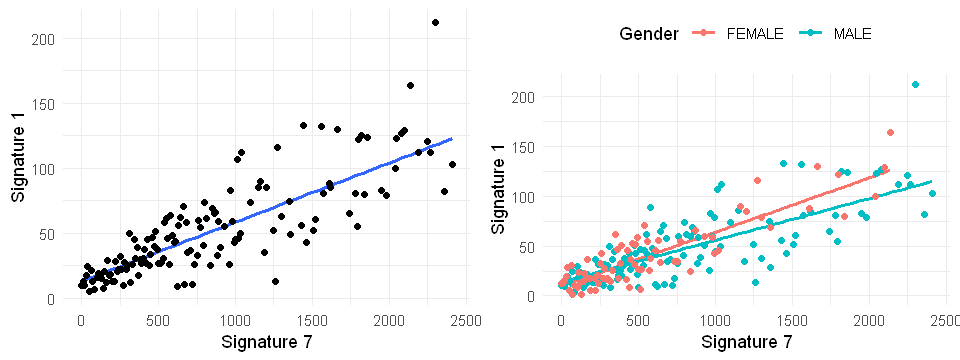

In [133]:
plot1 <- ggplot(subset(averages.sig7, Sig7Total<2500), aes(Sig7Total, Sig1Med)) +  geom_smooth(method = "rlm", se=FALSE) + geom_point() +
    xlab("Signature 7") + ylab("Signature 1") + theme_minimal()# + theme(legend.position="none")
plot2 <- ggplot(subset(averages.gender.sig7, Sig7Total<2500), aes(Sig7Total, Sig1Med, color=Gender)) +  geom_smooth(method = "rlm", se=FALSE) + geom_point() +
    xlab("Signature 7") + ylab("Signature 1") +# scale_y_continuous(limits = c(0,2000)) +
    theme_minimal() + theme(legend.position="top")
grid.arrange(plot1, plot2, ncol=2)
p <- arrangeGrob(plot1, plot2, ncol=2)

In [136]:
# Determine slope and intersept with corresponding P values for robust linear regression on all the data
cat("Spearman rho correlation between Signature 1 and Signature 7\n\n")
for (i in seq(1:2)) {
    sig1sig7cor <- cor.test(subset(data, Gender==genders[i])$Sig7Total, subset(data, Gender==genders[i])$Sig1Total, method="spearman", alternative="two.sided", exact=FALSE)
    cat("(", genders[i], ")", "Spearman correlation between Signature 1 and Signature 7:", sig1sig7cor$estimate, "with P-value", sig1sig7cor$p.value, "\n")
}

Spearman rho correlation between Signature 1 and Signature 7

( MALE ) Spearman correlation between Signature 1 and Signature 7: 0.7241306 with P-value 2.977074e-41 
( FEMALE ) Spearman correlation between Signature 1 and Signature 7: 0.6778582 with P-value 1.617965e-21 


###  <a id='chapter5'><font color="grey">  5. The proportion and spectra of intrinsic and extrinsic mutations varies according to gender.</font></a>

There is not a significant difference between the ratio of Signature 1 mutations and gender overall, and it is hard to really detect any differences.

In [137]:
# Compute averages in separate data frame (MALE)
agemale <- sort(unique(subset(data,Gender=="MALE")$Age)[!is.na(unique(subset(data,Gender=="MALE")$Age))])
averages.male.age <- data.frame(Age=agemale)
averages.male.age$Sig1Med <- NA
for (s in agemale) {
  i <- match(s,averages.male.age$Age)
  averages.male.age[i,c("Sig1Med")] <- median(data[which(data$agemale==s & data$Gender=="MALE"),"Sig1Total"])
}
# Compute averages in separate data frame (FEMALE)
agefemale <- sort(unique(subset(data,Gender=="FEMALE")$Age)[!is.na(unique(subset(data,Gender=="FEMALE")$Age))])
averages.female.age <- data.frame(Age=agefemale)
averages.female.age$Sig1Med <- NA
for (s in agefemale) {
  i <- match(s,averages.female.age$Age)
  averages.female.age[i,c("Sig1Med")] <- median(data[which(data$agefemale==s & data$Gender=="FEMALE"),"Sig1Total"])
}
averages.male.age$Gender <- "MALE"
averages.female.age$Gender <- "FEMALE"
averages.gender.sig7 <- rbind(averages.male.sig7, averages.female.sig7)

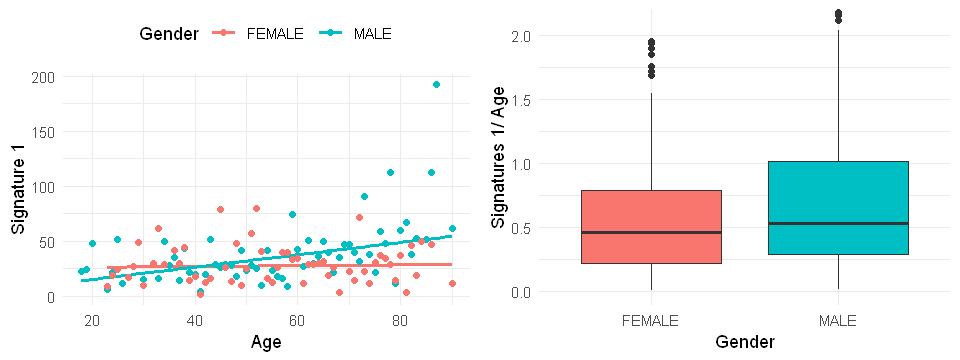

In [138]:
plot1 <- ggplot(averages.gender, aes(Age, Sig1Med, color=Gender)) +  geom_smooth(method = "rlm", se=FALSE) + geom_point() +
    xlab("Age") + ylab("Signature 1") +# scale_y_continuous(limits = c(0,2000)) +
    theme_minimal() + theme(legend.position="top")
plot2 <- ggplot(data, aes(Gender, Sig1Total/Age, fill=Gender)) +
    geom_boxplot() + ylab("Signatures 1/ Age") + theme_minimal() + coord_cartesian(ylim = c(0,2.1)) + 
    guides(fill=FALSE) + xlab("Gender")
grid.arrange(plot1, plot2, ncol=2)
p <- arrangeGrob(plot1, plot2, ncol=2)

In [139]:
ggsave("./figures/Figure4AB.pdf", plot=p, scale=1, width=8, height=4)

#### Spearman rho correlation and ratio test

In [140]:
correlation <- cor.test(averages$Age, averages$Sig1Med, method="spearman", alternative="greater", exact=FALSE)
cat("Spearman correlation with age on complete dataset:", correlation$estimate, "with P-value", correlation$p.value, "\n\n")
for (i in seq(1:2)) {
    tempdata <- subset(averages.gender, Gender==genders[i])
    correlation <- cor.test(tempdata$Age, tempdata$Sig1Med, method="spearman", alternative="two.sided", exact=FALSE)
    cat("Spearman rho correlation with age on", genders[i], "dataset:", correlation$estimate, "with P-value", correlation$p.value, "\n")
    }

Spearman correlation with age on complete dataset: 0.4057697 with P-value 0.0002984914 

Spearman rho correlation with age on MALE dataset: 0.5307039 with P-value 7.670654e-06 
Spearman rho correlation with age on FEMALE dataset: 0.05816843 with P-value 0.6616681 


In [145]:
# Wilcoxon rank sum test
newdata.male <- subset(averages.gender, Gender=='MALE')
newdata.female <- subset(averages.gender, Gender=='FEMALE')
cat(median(newdata.male$Sig1Med/newdata.male$Age)/median(newdata.female$Sig1Med/newdata.female$Age),"\n")
pwres <- wilcox.test(newdata.male$Sig1Med/newdata.male$Age, newdata.female$Sig1Med/newdata.female$Age, exact=FALSE, pairwise=FALSE)
cat("P-value for Male vs Female:", pwres$p.value, '\n')

1.294021 
P-value for Male vs Female: 0.02434282 


In [165]:
# Wilcoxon rank sum test by cohorts
for (i in seq(4)) {
    newdata.male <- subset(data, Gender=='MALE' & Cohort==cohorts[i])
    newdata.female <- subset(data, Gender=='FEMALE' & Cohort==cohorts[i])
    pwres <- wilcox.test(newdata.male$Sig1Total/newdata.male$Age, newdata.female$Sig1Total/newdata.female$Age, exact=FALSE, pairwise=FALSE)
    cat("P-value for Male vs Female in", cohorts[i], ":", pwres$p.value, "\n")
    }

P-value for Male vs Female in BRAF : 0.05444241 
P-value for Male vs Female in NRAS : 0.6894203 
P-value for Male vs Female in NF1 : 0.4427601 
P-value for Male vs Female in W3 : 0.6144461 


In [ ]:
d

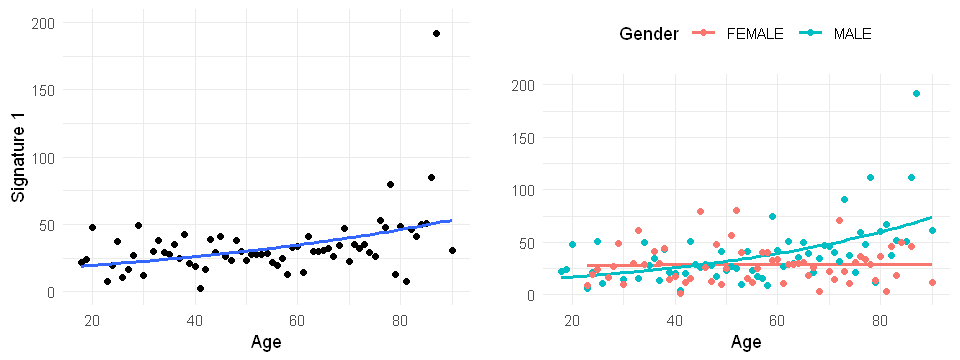

In [142]:
plot1 <- ggplot(averages, aes(Age, Sig1Med)) +  geom_point() +
    geom_smooth(method = "glm", aes(Age, as.integer(Sig1Med)), formula = y ~ x, data=averages, se=FALSE, method.args = (family="poisson")) +
    xlab("Age") + ylab("Signature 1") + theme_minimal() + coord_cartesian(ylim = c(0,200))# + theme(legend.position="none")
plot2 <- ggplot(averages.gender, aes(Age, Sig1Med, color=Gender)) +  
    geom_smooth(method = "glm", aes(Age, as.integer(Sig1Med)), formula = y ~ x, data=averages.gender, se=FALSE, method.args = (family="poisson")) + 
    geom_point() + xlab("Age") + ylab("") + theme_minimal() + theme(legend.position="top") + coord_cartesian(ylim = c(0,200))
p <- arrangeGrob(plot1, plot2, ncol=2)
grid.arrange(plot1, plot2, ncol=2)

In [143]:
ggsave("./figures/Figure4CD.pdf", plot=p, scale=1, width=8, height=4)

Estimate the $\alpha$ parameter for male and female.

In [156]:
res.male <- glm.nb(as.integer(Sig1Med) ~ Age, data=averages.male)
alpha.male <- coef(res.male)["Age"]
cat(alpha.male, 1/alpha.male, "\n")
res.female <- glm.nb(as.integer(Sig1Med) ~ Age, data=averages.female)
alpha.female <- coef(res.female)["Age"]
cat(alpha.female, 1/alpha.female, "\n")

0.01774896 56.34132 
0.0005444855 1836.596 


In [157]:
expfun.male <- function(x) {
    return(unname(exp(coef(res.male)["(Intercept)"]))*exp(unname(coef(res.male)["Age"])*x)/x)
    }
expfun.female <- function(x) {
    return(exp(unname(coef(res.female)["(Intercept)"]))*exp(unname(coef(res.female)["Age"])*x)/x)
    }

In [158]:
line.male <- data.frame(x = seq(20,90, by=0.1), y=sapply(seq(20,90, by=0.1), expfun.male))
line.female <- data.frame(x = seq(30,90, by=0.1), y=sapply(seq(30,90, by=0.1), expfun.female))

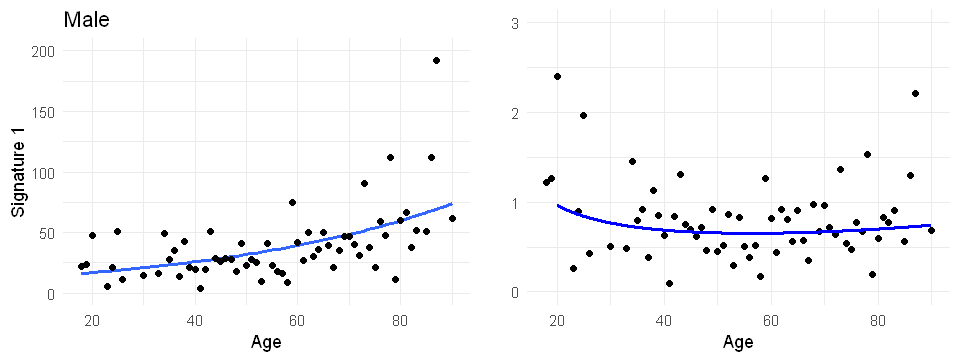

In [178]:
plot1 <- ggplot(averages.male, aes(Age, Sig1Med)) +  
    geom_smooth(method = "glm", aes(Age, as.integer(Sig1Med)), formula = y ~ x, data=averages.male, se=FALSE, method.args = (family="poisson")) + 
    geom_point() + xlab("Age") + ylab("Signature 1") + ggtitle('Male')+theme_minimal() + theme(legend.position="top") + coord_cartesian(ylim = c(0,200))
plot2 <- ggplot(averages.male, aes(Age, Sig1Mean/Age)) + geom_point() +
    xlab("Age") + ylab("") + theme_minimal() + theme(legend.position="none") + coord_cartesian(ylim = c(0,3))+ geom_line(data=line.male, aes(x, y), color="blue", size=1)
grid.arrange(plot1, plot2, ncol=2, nrow=1)
p <- arrangeGrob(plot1, plot2, ncol=2, nrow=1)

In [179]:
ggsave("./figures/Figure4CD.pdf", plot=p, scale=1, width=8, height=4)

#### Repeat the same thing in the presence of MC1R R alleles

#### Incorporate covariates
First, we use the model above with various covariates to determine which ones are significant. It turns out that all are.

In [173]:
res.simple <- glm.nb(as.integer(Sig1Total) ~ Age + Cohort, data=subset(data, Gender=='MALE'))
summary(res.simple)


Call:
glm.nb(formula = as.integer(Sig1Total) ~ Age + Cohort, data = subset(data, 
    Gender == "MALE"), init.theta = 1.59267649, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5658  -0.8926  -0.3384   0.3044   3.2046  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  2.665344   0.204125  13.057  < 2e-16 ***
Age          0.017692   0.003584   4.936 7.99e-07 ***
CohortNF1    0.430009   0.181425   2.370   0.0178 *  
CohortNRAS   0.187957   0.132149   1.422   0.1549    
CohortW3    -0.317865   0.143246  -2.219   0.0265 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for Negative Binomial(1.5927) family taken to be 1)

    Null deviance: 320.54  on 245  degrees of freedom
Residual deviance: 268.41  on 241  degrees of freedom
AIC: 2319.1

Number of Fisher Scoring iterations: 1


              Theta:  1.593 
          Std. Err.:  0.140 

 2 x log-likelihood:  -2307.077 

In [162]:
res.male <- glm.nb(as.integer(Sig1Total) ~ Age + Cohort + Gender, data=subset(data, Gender=="MALE"))
res.female <- glm.nb(as.integer(Sig1Total) ~ Age + Cohort + Gender, data=subset(data, Gender=="FEMALE"))

ERROR: Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]): contrasts can be applied only to factors with 2 or more levels


Study whether MC1R status is relevant. 

In [ ]:
res.simple <- glm(as.integer(Sig1Total) ~ Age + Gender + Cohort + Rallele, data=mydata, family="poisson")
factor.allele <- exp(coef(res.simple)["Rallele1-2 R alleles"])
cat("The precense of 1-2 MC1R alleles contributes to a multiplicative increase factor of", factor.allele, "across all subtypes.")

In [ ]:
res.simple <- glm(as.integer(Sig1Total) ~ Age + Gender + Cohort + Rallele + Sig7Total, data=mydata, family="poisson")
factor.allele <- exp(coef(res.simple)["Rallele1-2 MC1R alleles"])
cat("The precense of 1-2 MC1R alleles contributes to a multiplicative increase factor of", factor.allele, "across BRAF subtypes.\n")

In [ ]:
res.exp.male <- glm(as.integer(Sig1Total) ~ Age + Sig7Total + Cohort + Site, data = subset(data, Gender=="MALE"), family="poisson")
res.exp.female <- glm(as.integer(Sig1Total) ~ Age + Sig7Total + Cohort + Site, data = subset(data, Gender=="FEMALE"), family="poisson")
N0.male <- exp(coef(res.exp.male)["(Intercept)"])
alpha.male <- coef(res.exp.male)["Age"]
N0.female <- exp(coef(res.exp.female)["(Intercept)"])
alpha.female <- coef(res.exp.female)["Age"]
Sig7.male <- coef(res.exp.male)["Sig7Total"]
Sig7.female <- coef(res.exp.female)["Sig7Total"]
cat(N0.male, "\n")
cat(alpha.male, "\n")
cat(N0.female, "\n")
cat(alpha.female, "\n")
cat(Sig7.male, "\n")
cat(Sig7.female, "\n")